In [1]:
###Ryan Blow
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pathlib import Path
import pickle

In [37]:
class Model(nn.Module):
    def __init__(self, tendrills):
        """
        Input:
            (N,784)
        Returns:
            dense (N, 90)
        """
        super(Model, self).__init__()  
        self.conv1 = nn.Conv2d(1, 5, (5, 5))
        self.conv2 = nn.Conv2d(5, 10, (5, 5))
        self.dense1=nn.Linear(160, 700)
        self.dense2=nn.Linear(700, 500)
        self.dense3=nn.Linear(500, 100)
        self.dense4=nn.Linear(100, tendrills)
        weights1=np.load("dense1.npy")
        self.dense1.weight.data=torch.tensor(weights1, dtype= torch.float)
        weights2=np.load("dense2.npy")
        self.dense2.weight.data=torch.tensor(weights2, dtype= torch.float)
        weights3=np.load("dense3.npy")
        self.dense3.weight.data=torch.tensor(weights3, dtype= torch.float)
        weights4=np.load("dense4.npy")
        self.dense4.weight.data=torch.tensor(weights4, dtype= torch.float)
    def forward(self, x):
        """
        
        Put in a (N, 784) array and it outputs it as a (N, 90) array to softmax
        
        
        """
        x = self.conv1(x)
        x = F.max_pool2d(x, (2, 2), 2)
        x = self.conv2(x)
        x = F.max_pool2d(x, (2, 2), 2)
        x=x.reshape(x.shape[0], -1)
        one=F.relu(self.dense1(x))
        two=F.relu(self.dense2(one))
        three=F.relu(self.dense3(two))
        return self.dense4(three)

    def weights1(self):
        weights=self.dense1.weight
        return weights
    def weights2(self):
        weights=self.dense2.weight
        return weights
    def weights3(self):
        weights=self.dense3.weight
        return weights
    def weights4(self):
        weights=self.dense4.weight
        return weights
   

In [27]:
###Initializes the dictionary
img_dic={}
root=Path(".")
files=sorted(Path(root / "quickdraw").glob('*.npy'))
for i in range(len(files)):
    img = np.load(str(files[i]))
    true=np.zeros(90)
    true[i]=1
    file_location=str(files[i])
    file_name_npy=file_location[32:]
    file_name=file_name_npy[0:(len(file_name_npy)-4)]
    N = img.shape[0]
    img_lists=[]
    all_imgs = img.reshape((N, 28,28))
    for j in range(int(N/100)):
        img_single= all_imgs[j]
        img_lists.append([img_single,true])
    image_name=file_name
    img_dic[image_name]=img_lists
    print(len(img_lists))
print("pickling")
print(len(img_lists))

1165
1447
3079
1353
1337
1181
1208
1335
1449
1302
1179
1287
1827
1225
1232
1211
2227
1228
1205
1202
1276
1313
1299
1340
1307
1315
1521
1216
1407
1354
1579
1228
1348
1258
2257
1341
1448
2030
1260
1238
1204
2917
2854
2226
1424
1263
1819
1359
1354
1231
1726
2615
1255
1435
1205
1216
1788
1799
1341
1529
1421
1585
1975
1594
1501
1442
2537
1867
1187
1552
1546
1365
1261
1249
1243
1222
1166
3400
2094
1251
1184
1376
1337
1280
1231
1240
1165
1366
1323
1200
pickling
1200


<IPython.core.display.Javascript object>


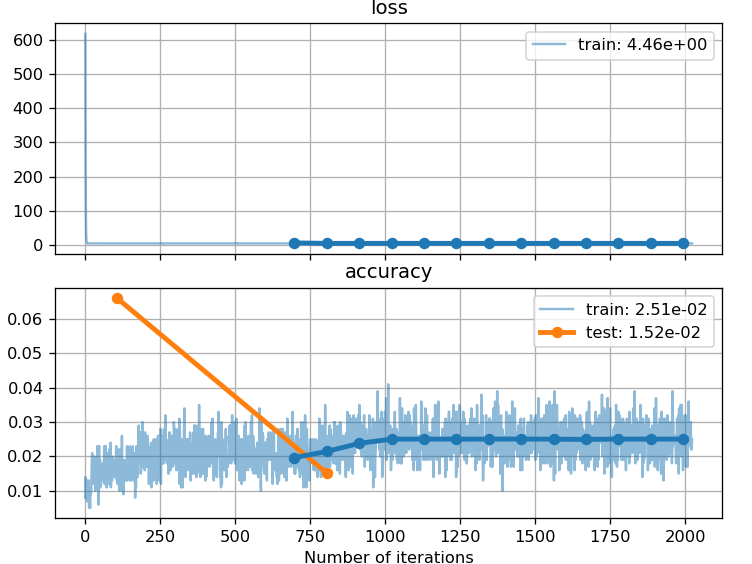

In [38]:
import liveplot
%matplotlib notebook
plotter, fig, ax = liveplot.create_plot(metrics=["loss", "accuracy"], refresh=5)

In [39]:
model= Model(len(img_dic.keys()))
optimizer = optim.Adam(model.parameters())
cross_entropy = nn.CrossEntropyLoss()

In [32]:
###the dictionary's values is a list of a list of a list of 2 np arrays
img_values_list=[i for i in img_dic.values()]
#test=28945*90=2605050
#train=115777*90=10419930
#overall=13024980
train_imgs=[]
train_true=[]
test_img=[]
test_true=[]
for i in range(len(img_values_list)):
    for j in range(int(np.around((len(img_values_list[i])*4)/5))):
        train_imgs.append(img_values_list[i][j][0])
        train_true.append(i)
    for j in range(int(np.around((len(img_values_list[i])*4)/5))+1,len(img_values_list[i])):
        test_img.append(img_values_list[i][j][0])
        test_true.append(i) 
train_imgs=np.array(train_imgs)
train_true=np.array(train_true)
test_img=np.array(test_img)
test_true=np.array(test_true)
print("done train array making")

done train array making


In [33]:
batch_size = 1000
mean=0
train_imgs=train_imgs.reshape((train_imgs.shape[0], 1, 28, 28))
test_img=test_img.reshape((test_img.shape[0], 1, 28, 28))
test_img=test_img.reshape(test_img.shape[0], 784)
train_imgs=train_imgs.reshape(train_imgs.shape[0], 784)
deviation=np.std(train_imgs, axis=0)
for i in range(len(deviation)):
    if deviation[i]==0:
        deviation[i]=1
mean=np.mean(train_imgs, axis=0)
for i in range(5):
    print("yes")
    test_img[(int(len(test_img)*i/5)):(int(len(test_img)*(i+1)/5))]=(test_img[(int(len(test_img)*i/5)):(int(len(test_img)*(i+1)/5))]-mean)/deviation
for i in range(5):
    print("yes")
    train_imgs[(int(len(train_imgs)*i/5)):(int(len(train_imgs)*(i+1)/5))]=(train_imgs[(int(len(train_imgs)*i/5)):(int(len(train_imgs)*(i+1)/5))]-mean)/deviation
train_imgs=train_imgs.reshape((train_imgs.shape[0], 1, 28, 28))
test_img=test_img.reshape((test_img.shape[0], 1, 28, 28))
print("Done")

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
Done


In [43]:
# We will train for ~10 epochs; you can change this if you'd like
for epoch_cnt in range(1000):
    idxs = np.arange(len(train_imgs))  # -> array([0, 1, ..., 9999])
    np.random.shuffle(idxs)  
    for batch_cnt in range(0, len(train_imgs)//batch_size):
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = train_imgs[batch_indices]  # random batch of our training data

        batch=torch.tensor(batch).float()
        # compute the predictions for this batch by calling on model
        prediction=model(batch)
        # compute the true (a.k.a desired) values for this batch: 
        true=train_true[batch_indices]
        
        true=torch.tensor(true, dtype=torch.int64)
        # compute the loss associated with our predictions(use softmax_cross_entropy)
        
        loss=cross_entropy(prediction, true)
        # back-propagate through your computational graph through your loss
        loss.backward()
        # compute the accuracy between the prediction and the truth 
        acc_ind=0
        for i in range(len(prediction)):
            top_n, top_i = prediction[i].topk(1)  
            truth=true.detach().numpy()
            acc_ind+=(1.0 if int(top_i)==truth[i] else 0.0)
        acc=acc_ind/len(true)
        # execute gradient descent by calling step() of `optim`
        optimizer.step()
        weights1=model.weights1()
        weights2=model.weights2()
        weights3=model.weights3()
        weights4=model.weights4()
        # null your gradients (pleas e!)
        optimizer.zero_grad()
        # set the training loss and accuracy
        plotter.set_train_batch({"loss" : loss.item(),
                             "accuracy" : acc},
                             batch_size=batch_size)

    # Here, we evaluate our model on batches of *testing* data
    # this will show us how good our model does on data that 
    # it has never encountered
    # Iterate over batches of *testing* data
    plotter.plot_train_epoch()
    idxs = np.arange(len(test_img))
    for batch_cnt in range(0, len(test_img)//batch_size):
        batch_indices = slice(batch_cnt*batch_size, (batch_cnt + 1)*batch_size) # make as slice
        batch = test_img[batch_indices] 
        
        batch=torch.tensor(batch).float()
        # compute the predictions for this batch by calling on model
        prediction=model(batch)
        # compute the true (a.k.a desired) values for this batch: 
        true=train_true[batch_indices]
        
        true=torch.tensor(true, dtype=torch.int64)
        # compute the loss associated with our predictions(use softmax_cross_entropy)
        loss=cross_entropy(prediction, true)
        # compute the accuracy between the prediction and the truth 
        acc_ind=0
        for i in range(len(prediction)):
            top_n, top_i = prediction[i].topk(1)  
            truth=true.detach().numpy()
            acc_ind+=(1.0 if int(top_i)==truth[i] else 0.0)
        acc=acc_ind/len(true)
        # execute gradient descent by calling step() of `optim`

        # set the training loss and accuracy
        plotter.set_test_batch({"accuracy" : acc},
                             batch_size=batch_size)
    # this tells liveplot to plot the epoch-level train/test statistics :)
    
    plotter.plot_test_epoch()    
    np.save("dense1.npy", weights1.data.numpy())
    np.save("dense2.npy", weights2.data.numpy())
    np.save("dense3.npy", weights3.data.numpy())
    np.save("dense4.npy", weights4.data.numpy())
    print("done iteration")

done iteration
done iteration
done iteration
done iteration
done iteration


KeyboardInterrupt: 

In [14]:
###Reinitialize the model weights
"""from mynn.layers.dense import dense
from mynn.initializers.normal import normal
dense1=dense(100, 160, weight_initializer= normal)
dense4=dense(90, 100, weight_initializer= normal)
np.save("dense1", dense1.weight.data)
np.save("dense2", dense2.weight.data)
np.save("dense3", dense3.weight.data)
np.save("dense4", dense4.weight.data)
print("Done")"""

Done


In [20]:
weights1=np.load("dense4.npy")
weight4=torch.tensor(weights1.T, dtype= torch.float)
np.save("dense4.npy", weights4.data.numpy())